# [Imbalanced Data란?](https://rfriend.tistory.com/773)
불균형 데이터는(Imbalanced Data]는 목표변수(Target)가 범주형 데이터일 때, 범주별로 관측치의 개수, 비율의 차이가 많이 나는 데이터를 말합니다.



아래는 각 산업별 예시들입니다.

- 제조회사에서 양품 대 불량품
- 신용카드회사에서 정상 거래 대 사기 거래
- 은행의 정상 거래 대 돈세탁 거래
- 의료검진센터에서 장상 대 암 진단
- 사이버보안 회사에서 정상IP 대 비정상IP
- 통신회사에서 유지 고객 대 이탈 고객
- 설비/장비의 정상 대 이상 운영
- 유통회사 대리점의 정상 대 비정상 거래

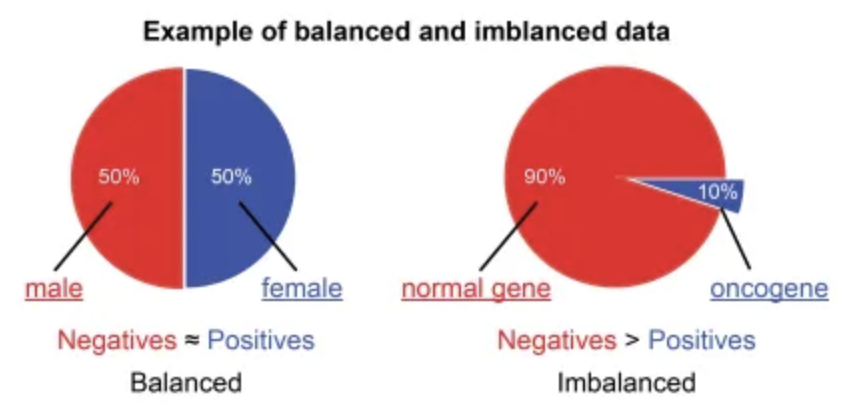

## 불균형 데이터를 이용한 모델링시 문제점

- 소수 집단(Minority Class)의 관측치 개수가 적으면 소수 집단의 모집단 분포를 샘플링한 소수의 관측치가 대표하기에는 부족하므로 분류 모델이 과적합(Overfitting)에 빠질 위함이 있습니다.
- 비정상(Minority Class)를 제대로 분류하지를 못하는 모델일 수 있습니다.
  - 정상(Majority Class) : 비정상(Minority Class)의 비율이 99:1이라고 한다면, 모델이 정상(Majority Class)만 학습을 하여도 정확도가 99%가 됩니다.

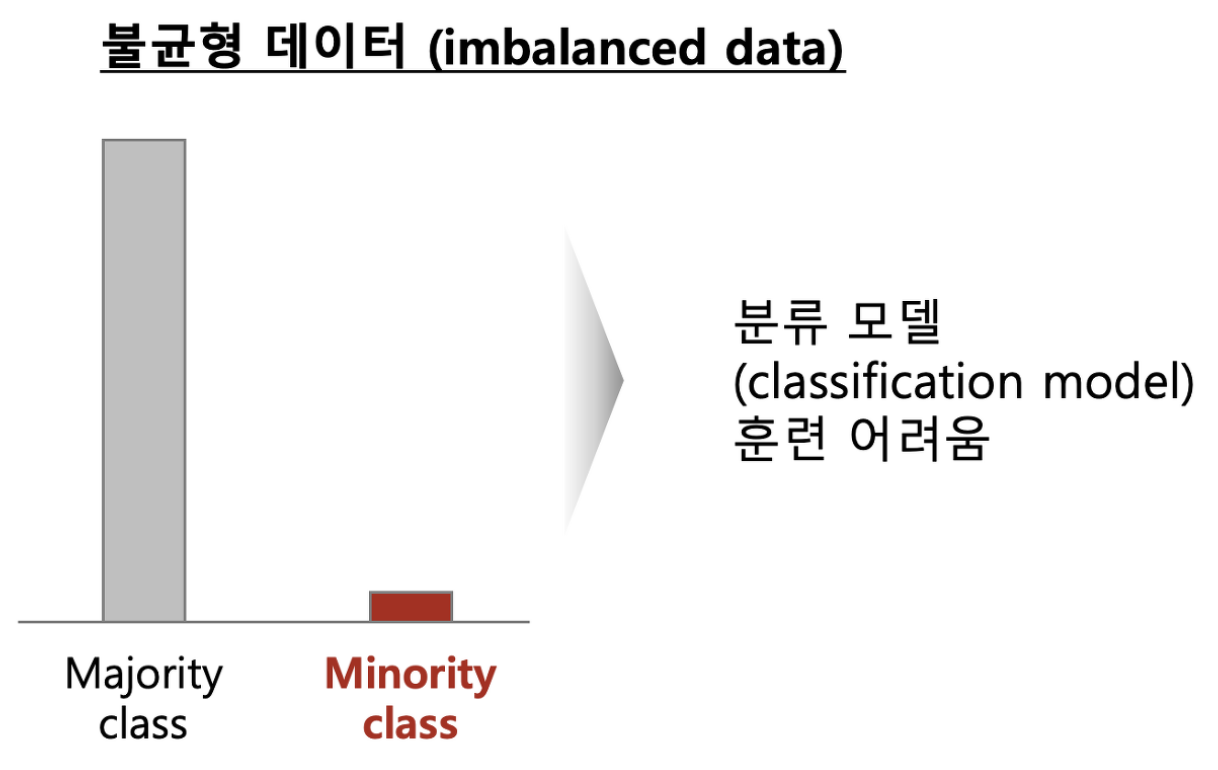

## [불균형 데이터 처리방법](https://databuzz-team.github.io/2018/10/21/Handle-Imbalanced-Data/)

### [평가기준 변경](https://medium.com/analytics-vidhya/machine-learning-metrics-in-simple-terms-d58a9c85f9f6)

- Confusion Matrix
  - 예측 결과를 테이블 형태로 보여준다.
- Precision
  - Positive 클래스에 속한다고 출력한 샘플 중 실제로 Positive 클래스에 속하는 샘플 수의 비율
- Recall
  - 실제 Positive 클래스에 속한 샘플 중에 Positive 클래스에 속한다고 출력한 표본의 수
- F1 Score
  - 정밀도(Precision)과 재현율(Recall)의 가중 조화 평균
- ROC Curves
  - ROC(Receiver Operator Characteristic) 커브는 클래스 판별 기준값의 변화에 따른 위양성률(fall-out)과 재현율(recall)의 변화를 시각화한 것이다.

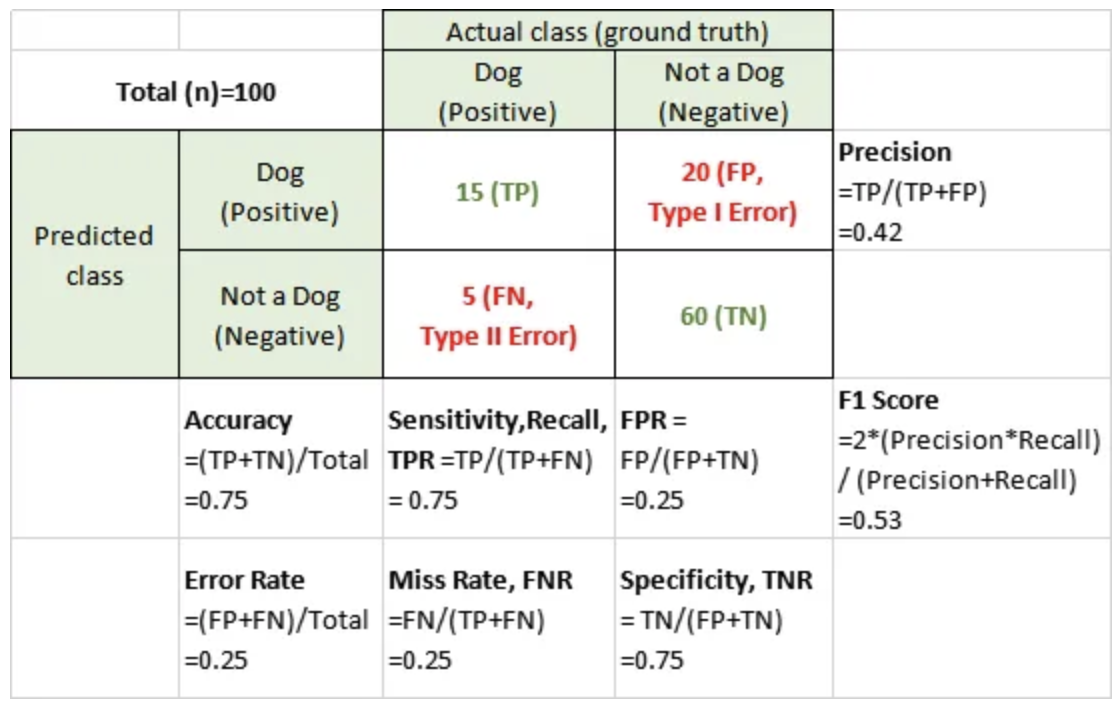

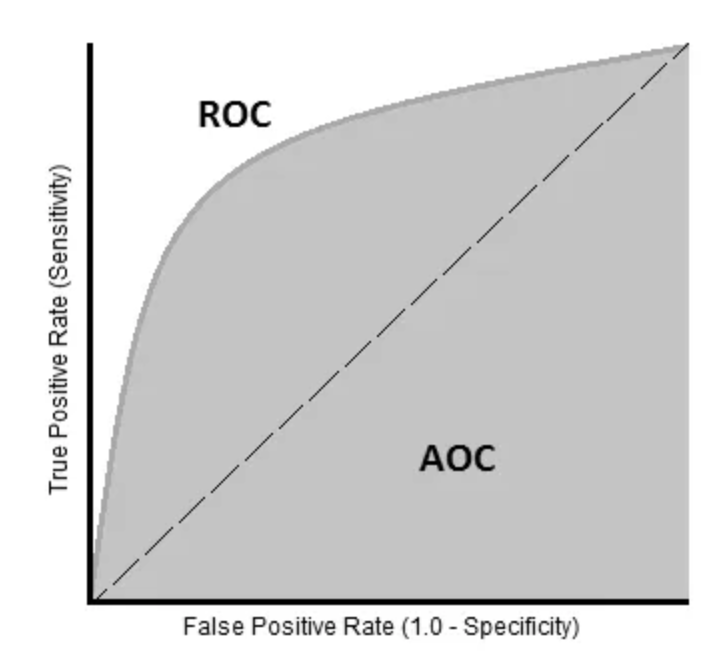

### [Resampling](https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html)

- 오버샘플링(Over-Sampling)
- 언더샘플링(Under-Sampling)

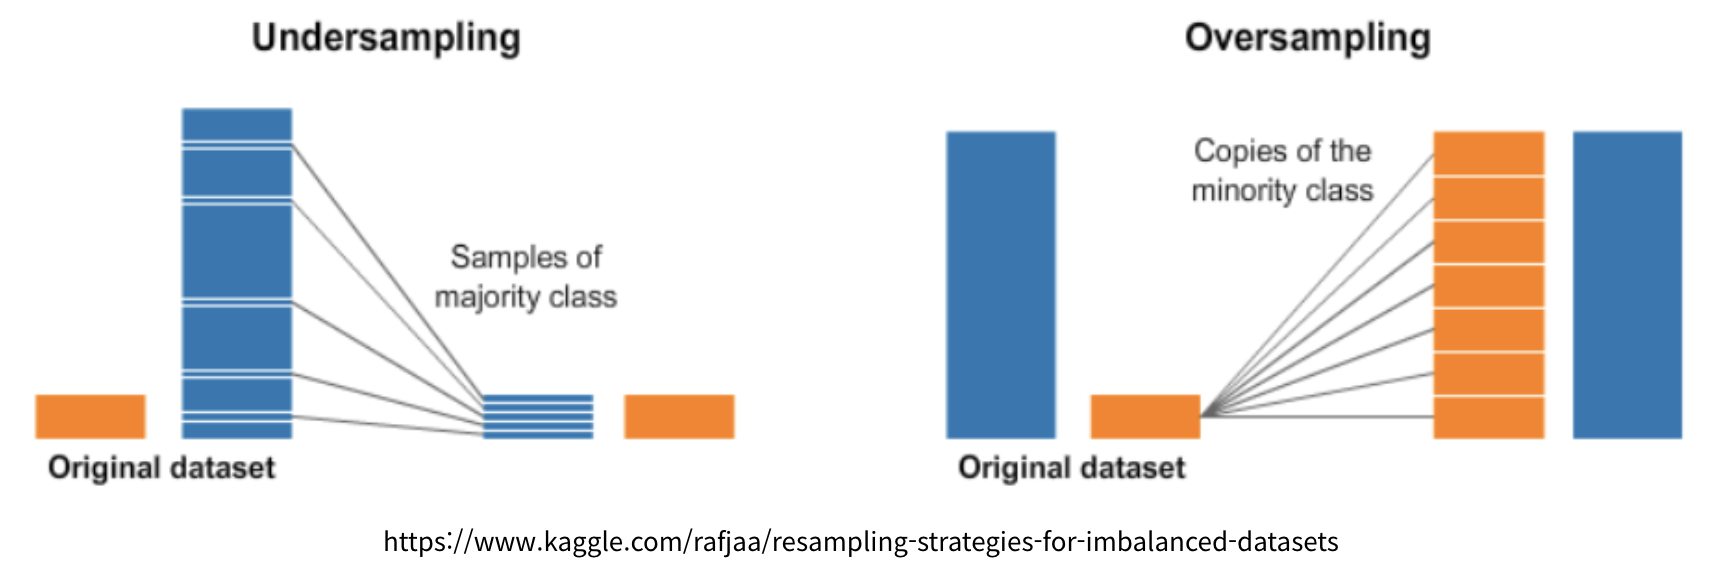

# 예제

## [적합한 성능평가 지표 선정](https://cypision.github.io/machine-learning/Imbalanced_Precision_Recall_Curve/)
- https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

In [1]:
# model
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
# split dataset
from sklearn.model_selection import train_test_split
# metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# analysis
import numpy as np
import pandas as pd

# numpy float 출력옵션 변경
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.6f}".format(x)})

import logging

logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [2]:
# 코렙 한글깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,986 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120831 files and dire

In [4]:
# plot no skill and model roc curves
def plot_roc_curve(test_y, naive_probs, model_probs,clf_name):
    # plot naive skill roc curve
    fpr, tpr, _ = roc_curve(test_y, naive_probs)
    plt.plot(fpr, tpr, linestyle='--', label='No Skill')
    # plot model roc curve
    fpr, tpr, _ = roc_curve(test_y, model_probs)
    plt.plot(fpr, tpr, marker='.', label=clf_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

- generate 2 class dataset
  - 99:1 비율로 불균형 데이터 생성

In [12]:
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99, 0.01], random_state=1)

X.shape, y.shape, np.unique(y)

((1000, 20), (1000,), array([0, 1]))

- split into train/test sets with same class ratio

In [13]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

trainX.shape, testX.shape, trainy.shape, testy.shape

((500, 20), (500, 20), (500,), (500,))

In [14]:
print('Dataset: Class0=%d, Class1=%d' % (len(y[y==0]), len(y[y==1])))
print('Train: Class0=%d, Class1=%d' % (len(trainy[trainy==0]), len(trainy[trainy==1])))
print('Test: Class0=%d, Class1=%d' % (len(testy[testy==0]), len(testy[testy==1])))

Dataset: Class0=985, Class1=15
Train: Class0=492, Class1=8
Test: Class0=493, Class1=7


### ROC-AUC Curve

- (No Skill)dummy model

In [27]:
model = DummyClassifier(strategy='stratified')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
print(yhat[0:5])

naive_probs = yhat[:, 1]
# calculate roc auc
dummy_roc_auc = roc_auc_score(testy, naive_probs)
print('No Skill ROC AUC %.3f' % dummy_roc_auc)

[[1.000000 0.000000]
 [1.000000 0.000000]
 [1.000000 0.000000]
 [1.000000 0.000000]
 [1.000000 0.000000]]
No Skill ROC AUC 0.489


- LogisticRegression

In [28]:
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
print(yhat.shape,'\n',yhat[0:5])

model_probs = yhat[:, 1]
# calculate roc auc
model_roc_auc = roc_auc_score(testy, model_probs)
print('Logistic ROC AUC %.3f' % model_roc_auc)

(500, 2) 
 [[0.957972 0.042028]
 [0.998611 0.001389]
 [0.993158 0.006842]
 [0.971323 0.028677]
 [0.999533 0.000467]]
Logistic ROC AUC 0.869


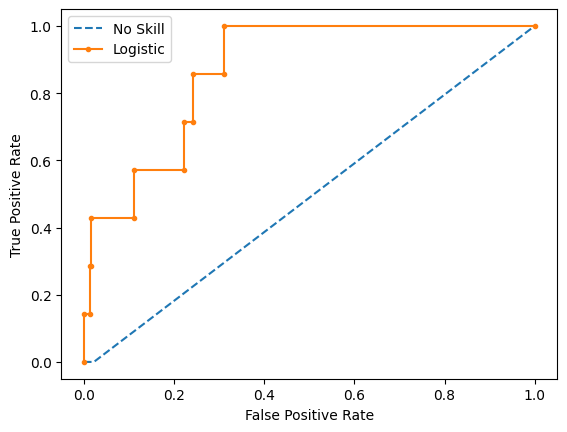

In [29]:
# plot roc curves
plot_roc_curve(testy, naive_probs, model_probs, clf_name='Logistic')

### Precision-Recall Curve

In [19]:
def plot_pr_curve(test_y, model_probs,clf_name):
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(test_y[test_y==1]) / len(test_y)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(testy, model_probs)
    plt.plot(recall, precision, marker='.', label=clf_name)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

- (No Skill)dummy model

In [30]:
model = DummyClassifier(strategy='stratified')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
print(yhat[0:5])

naive_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, naive_probs)
dummy_auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % dummy_auc_score)

[[1.000000 0.000000]
 [1.000000 0.000000]
 [1.000000 0.000000]
 [1.000000 0.000000]
 [1.000000 0.000000]]
No Skill PR AUC: 0.007


- LogisticRegression

In [31]:
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
print(yhat.shape,'\n',yhat[0:5])

model_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, model_probs)
model_auc_score = auc(recall, precision)
print('Logistic PR AUC: %.3f' % model_auc_score)

(500, 2) 
 [[0.957972 0.042028]
 [0.998611 0.001389]
 [0.993158 0.006842]
 [0.971323 0.028677]
 [0.999533 0.000467]]
Logistic PR AUC: 0.228


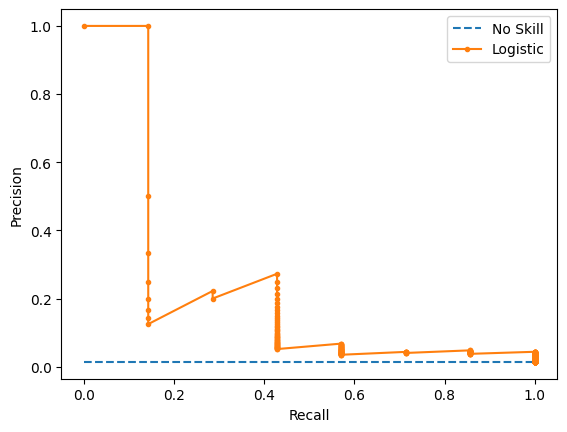

In [32]:
# plot precision-recall curves
plot_pr_curve(testy, model_probs,clf_name='Logistic')

### 해석
ROC_AUC의 값이 전체적으로 후하다는 것을 알 수 있다. 이를 이해하기 위해서는 두 metric이 전달하고자 하는 의미를 이해하는 것이 중요하다.
- ROC_AUC: 모든 class에 대한 종합적인 평가
- PR_AUC: Positive class에 대한 평가(즉, minor class)

따라서 불균형 데이터를 평가할 때는, PR_AUC를 사용하는 것이 좋다.

In [33]:
print(f'No Skill ROC AUC: {dummy_roc_auc} / Logistic ROC AUC: {model_roc_auc}')
print('======================================================================')
print(f'No Skill PR AUC: {dummy_auc_score} / Logistic PR AUC: {model_auc_score}')

No Skill ROC AUC: 0.48884381338742394 / Logistic ROC AUC: 0.8690234714575485
No Skill PR AUC: 0.007 / Logistic PR AUC: 0.2277031894942569


## [Resampling](https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html)

In [3]:
from sklearn.datasets import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.svm import SVC

import scipy as sp

In [4]:
def classification_result(n0, n1, title=""):
    rv1 = sp.stats.multivariate_normal([-1, 0], [[1, 0], [0, 1]])
    rv2 = sp.stats.multivariate_normal([+1, 0], [[1, 0], [0, 1]])
    X0 = rv1.rvs(n0, random_state=0)
    X1 = rv2.rvs(n1, random_state=0)
    X = np.vstack([X0, X1])
    y = np.hstack([np.zeros(n0), np.ones(n1)])

    x1min = -4; x1max = 4
    x2min = -2; x2max = 2
    xx1 = np.linspace(x1min, x1max, 1000)
    xx2 = np.linspace(x2min, x2max, 1000)
    X1, X2 = np.meshgrid(xx1, xx2)

    plt.contour(X1, X2, rv1.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    plt.contour(X1, X2, rv2.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")

    model = SVC(kernel="linear", C=1e4, random_state=0).fit(X, y)
    Y = np.reshape(model.predict(np.array([X1.ravel(), X2.ravel()]).T), X1.shape)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='x', label="0 클래스")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', label="1 클래스")
    plt.contour(X1, X2, Y, colors='k', levels=[0.5])
    y_pred = model.predict(X)
    plt.xlim(-4, 4)
    plt.ylim(-3, 3)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)

    return model, X, y, y_pred

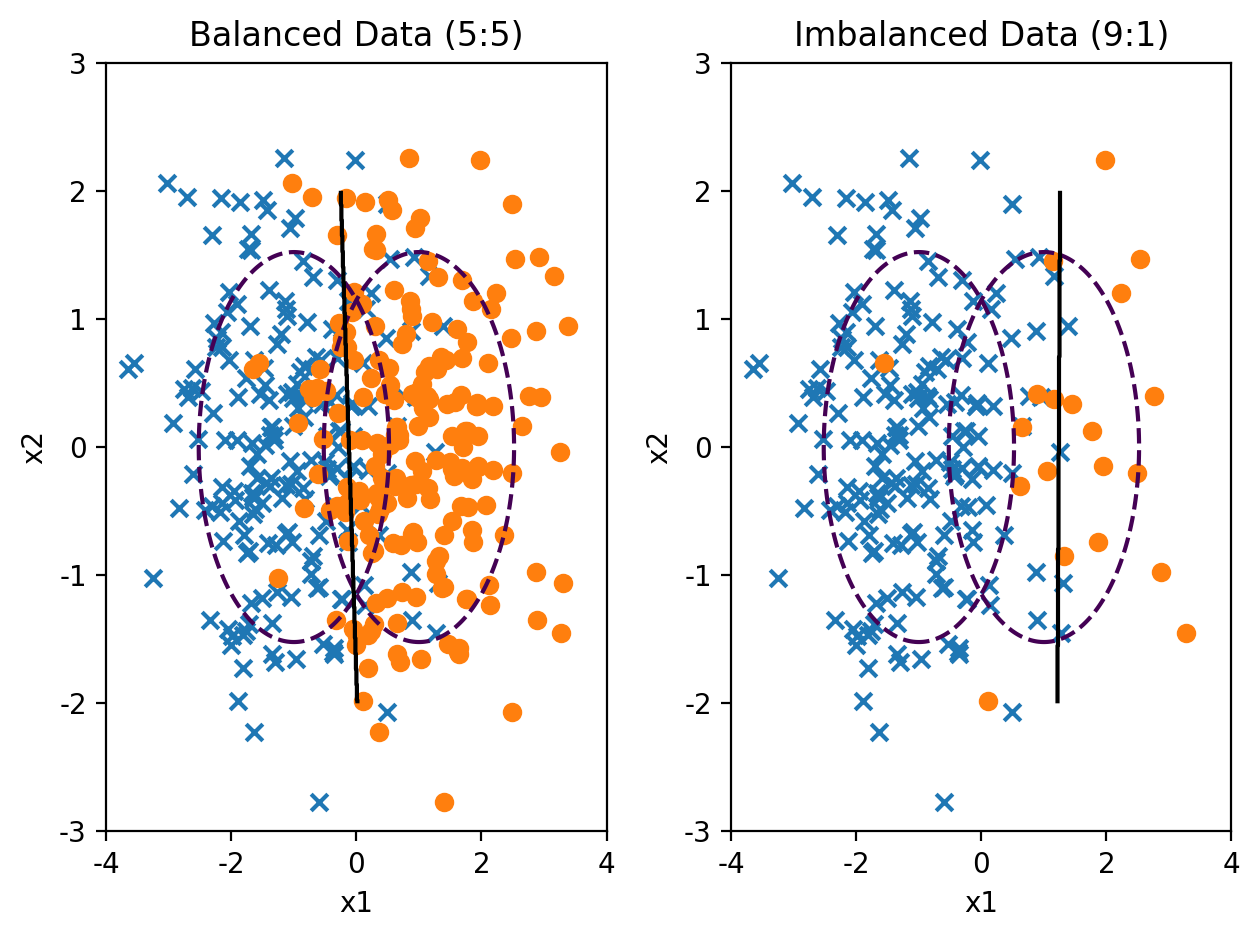

In [6]:
plt.subplot(121)
model1, X1, y1, y_pred1 = classification_result(200, 200, "Balanced Data (5:5)")
plt.subplot(122)
model2, X2, y2, y_pred2 = classification_result(200, 20, "Imbalanced Data (9:1)")
plt.tight_layout()
plt.show();

아래 결과로 알 수 있듯이,    
- 불균형 데이터인 경우에 accuracy가 더 높은 것을 알 수 있다.
- recall > f1-score > precision > accuracy

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y1, y_pred1))
print('==============================================================')
print(classification_report(y2, y_pred2))

              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84       200
         1.0       0.84      0.86      0.85       200

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       200
         1.0       0.75      0.60      0.67        20

    accuracy                           0.95       220
   macro avg       0.86      0.79      0.82       220
weighted avg       0.94      0.95      0.94       220



### Imbalanced-learn 패키지

```shell
# 설치방법
$ pip install -U imbalanced-learn
```

In [12]:
def classification_result2(X, y, title=""):
    plt.contour(X1, X2, rv1.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    plt.contour(X1, X2, rv2.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    model = SVC(kernel="linear", C=1e4, random_state=0).fit(X, y)
    Y = np.reshape(model.predict(np.array([X1.ravel(), X2.ravel()]).T), X1.shape)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='x', label="0 클래스")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', label="1 클래스")
    plt.contour(X1, X2, Y, colors='k', levels=[0.5])
    y_pred = model.predict(X)
    plt.xlim(-4, 4)
    plt.ylim(-3, 3)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    return model

In [13]:
n0 = 200; n1 = 20
rv1 = sp.stats.multivariate_normal([-1, 0], [[1, 0], [0, 1]])
rv2 = sp.stats.multivariate_normal([+1, 0], [[1, 0], [0, 1]])
X0 = rv1.rvs(n0, random_state=0)
X1 = rv2.rvs(n1, random_state=0)
X_imb = np.vstack([X0, X1])
y_imb = np.hstack([np.zeros(n0), np.ones(n1)])

x1min = -4; x1max = 4
x2min = -2; x2max = 2
xx1 = np.linspace(x1min, x1max, 1000)
xx2 = np.linspace(x2min, x2max, 1000)
X1, X2 = np.meshgrid(xx1, xx2)

### 언더샘플링(Under-Sampling)

#### RandomUnderSampler
- 무작위로 데이터를 없애는 단순 샘플링

In [14]:
from imblearn.under_sampling import RandomUnderSampler

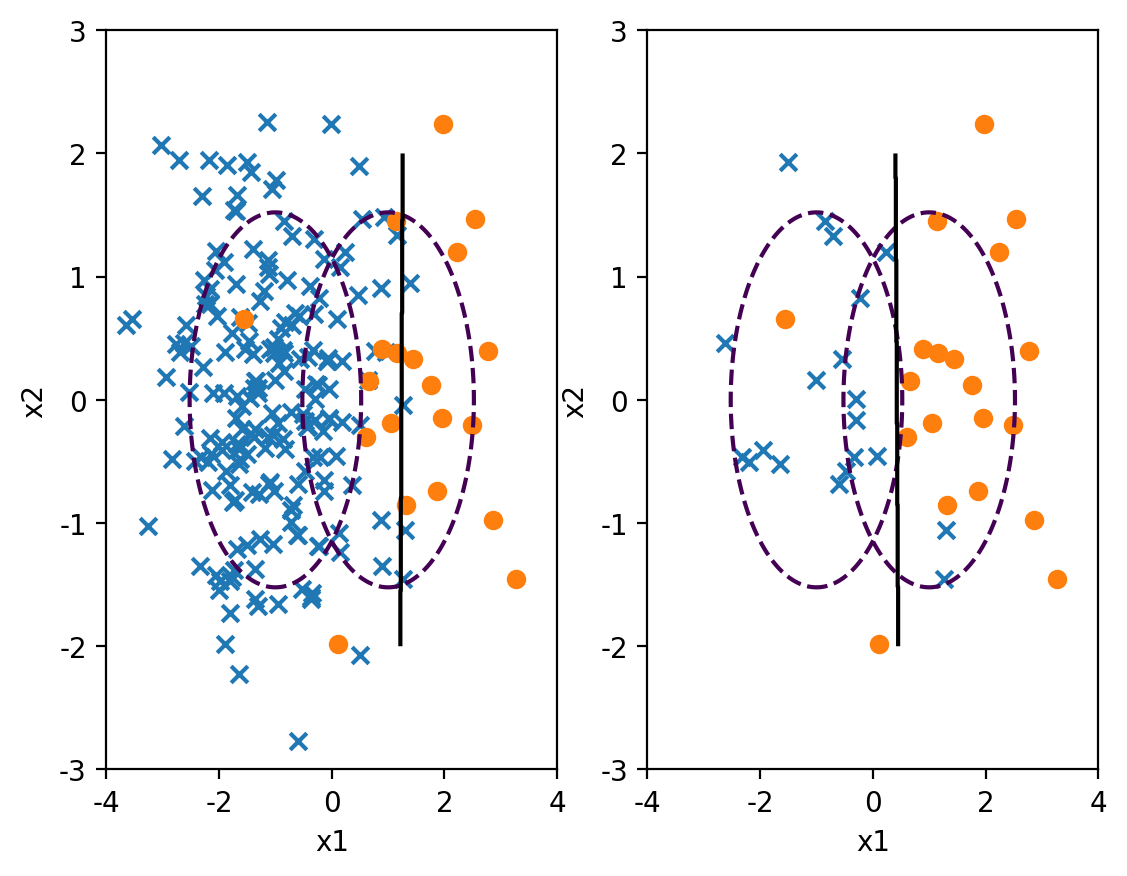

In [16]:
X_samp, y_samp = RandomUnderSampler(random_state=0).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [17]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       200
         1.0       0.51      0.90      0.65        20

    accuracy                           0.91       220
   macro avg       0.75      0.91      0.80       220
weighted avg       0.95      0.91      0.92       220



#### OneSidedSelection
- One Sided Selection은 토맥링크 방법과 Condensed Nearest Neighbour 방법을 섞은 것이다.
- 토맥링크 중 다수 클래스를 제외하고 나머지 데이터 중에서도 서로 붙어있는 다수 클래스 데이터는 1-NN 방법으로 제외한다.

In [19]:
from imblearn.under_sampling import OneSidedSelection

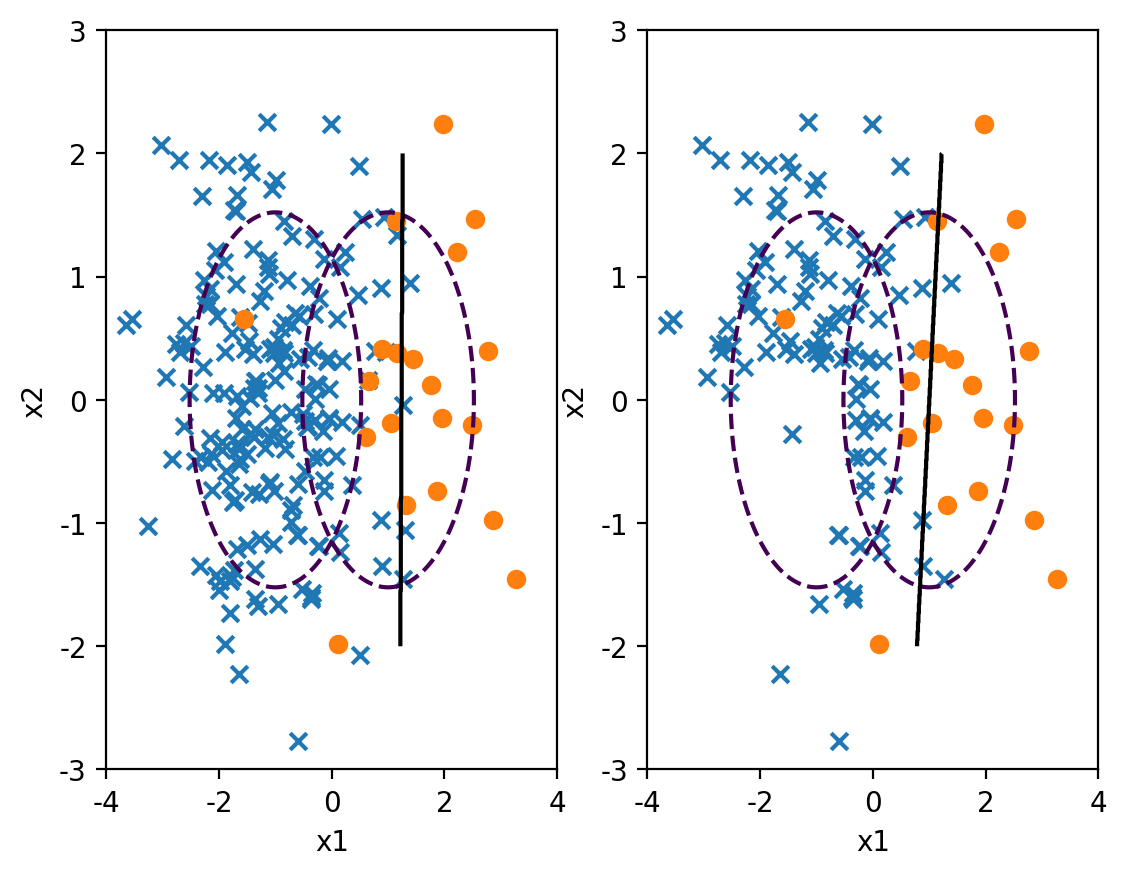

In [21]:
X_samp, y_samp = OneSidedSelection(random_state=0).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [22]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       200
         1.0       0.70      0.70      0.70        20

    accuracy                           0.95       220
   macro avg       0.83      0.83      0.83       220
weighted avg       0.95      0.95      0.95       220



#### NeighbourhoodCleaningRule
- Neighbourhood Cleaning Rule 방법은 CNN(Condensed Nearest Neighbour) 방법과 ENN(Edited Nearest Neighbours) 방법을 섞은 것이다.

In [23]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

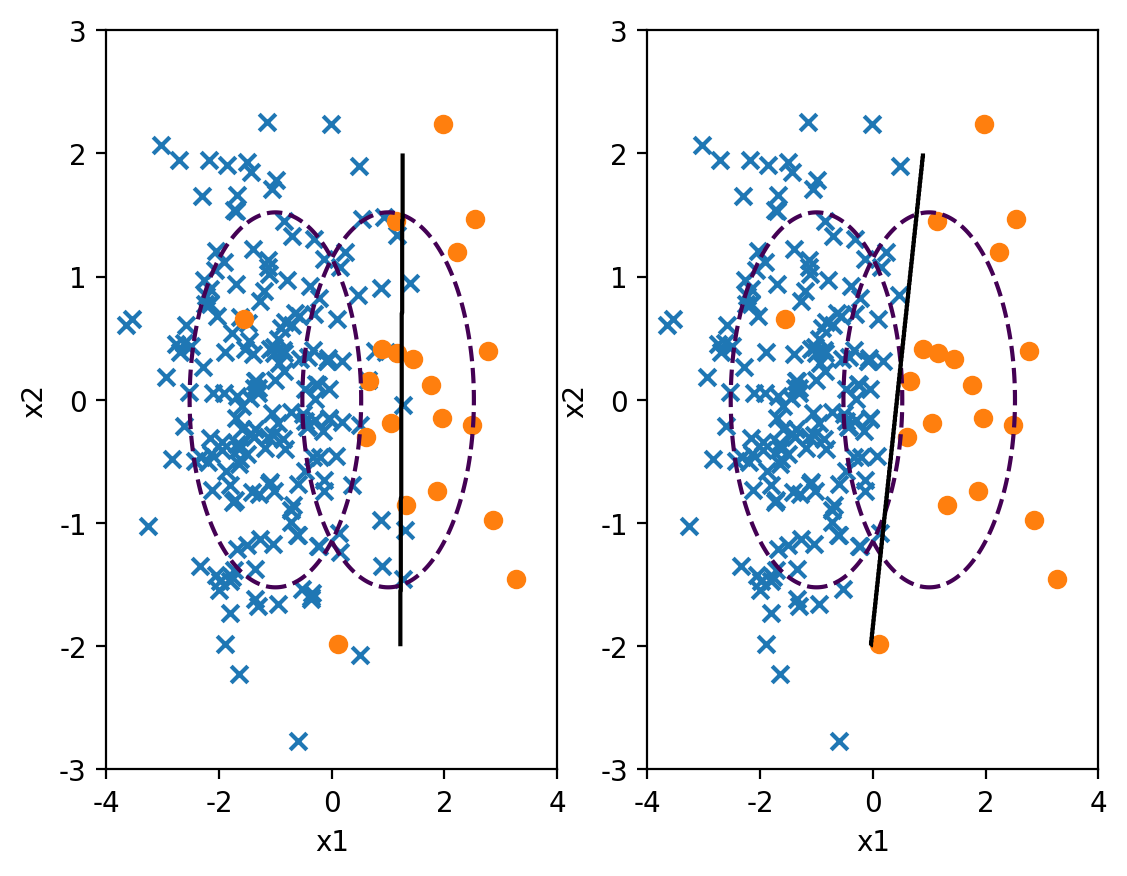

In [25]:
X_samp, y_samp = NeighbourhoodCleaningRule(kind_sel="all", n_neighbors=5).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [26]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       200
         1.0       0.56      0.95      0.70        20

    accuracy                           0.93       220
   macro avg       0.78      0.94      0.83       220
weighted avg       0.96      0.93      0.94       220



### 오버샘플링(Over-Sampling)

#### RandomOverSampler
- Random Over Sampling은 소수 클래스의 데이터를 반복해서 넣는 것(replacement)이다. 가중치를 증가시키는 것과 비슷하다.

In [27]:
from imblearn.over_sampling import RandomOverSampler

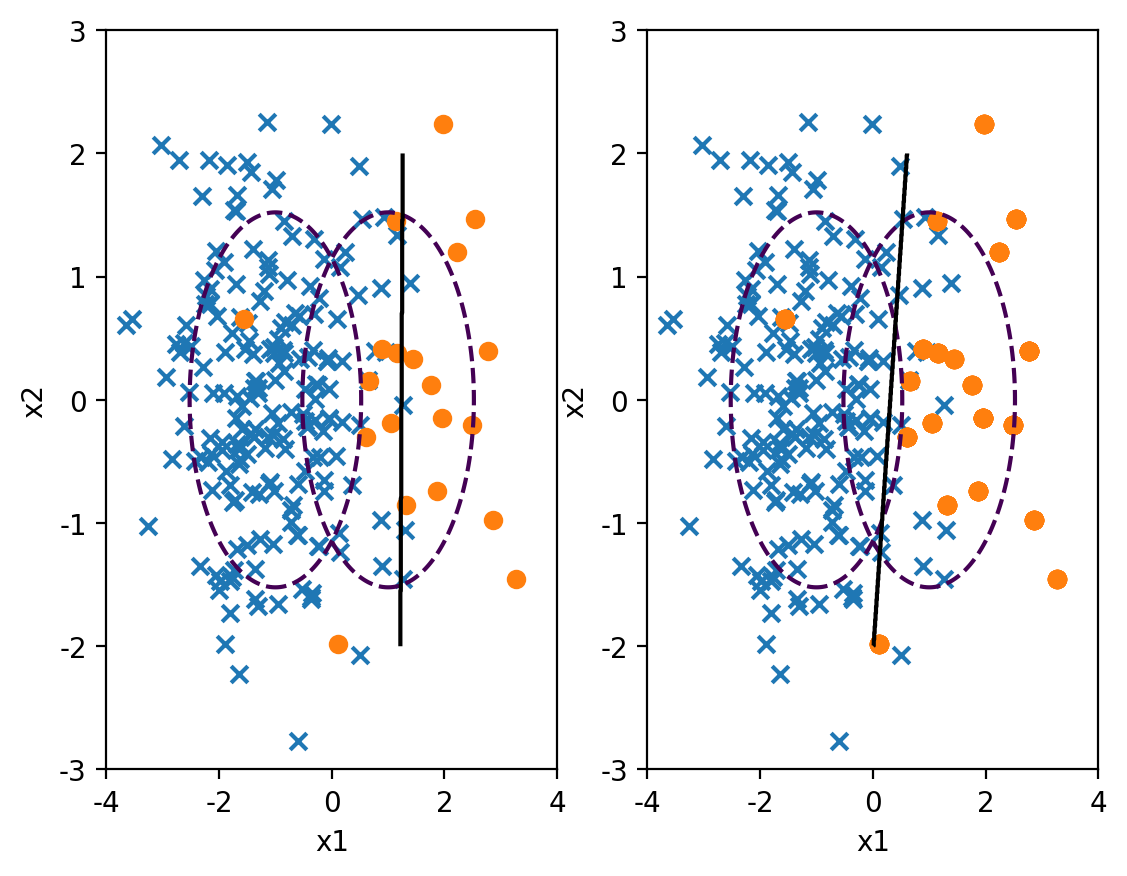

In [28]:
X_samp, y_samp = RandomOverSampler(random_state=0).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [29]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95       200
         1.0       0.51      0.95      0.67        20

    accuracy                           0.91       220
   macro avg       0.75      0.93      0.81       220
weighted avg       0.95      0.91      0.92       220



#### ADASYN(Adaptive Synthetic Sampling)
- ADASYN 방법은 소수 클래스 데이터와 그 데이터에서 가장 가까운 k개의 소수 클래스 데이터 중 무작위로 선택된 데이터 사이의 직선상에 가상의 소수 클래스 데이터를 만드는 방법이다.

In [30]:
from imblearn.over_sampling import ADASYN

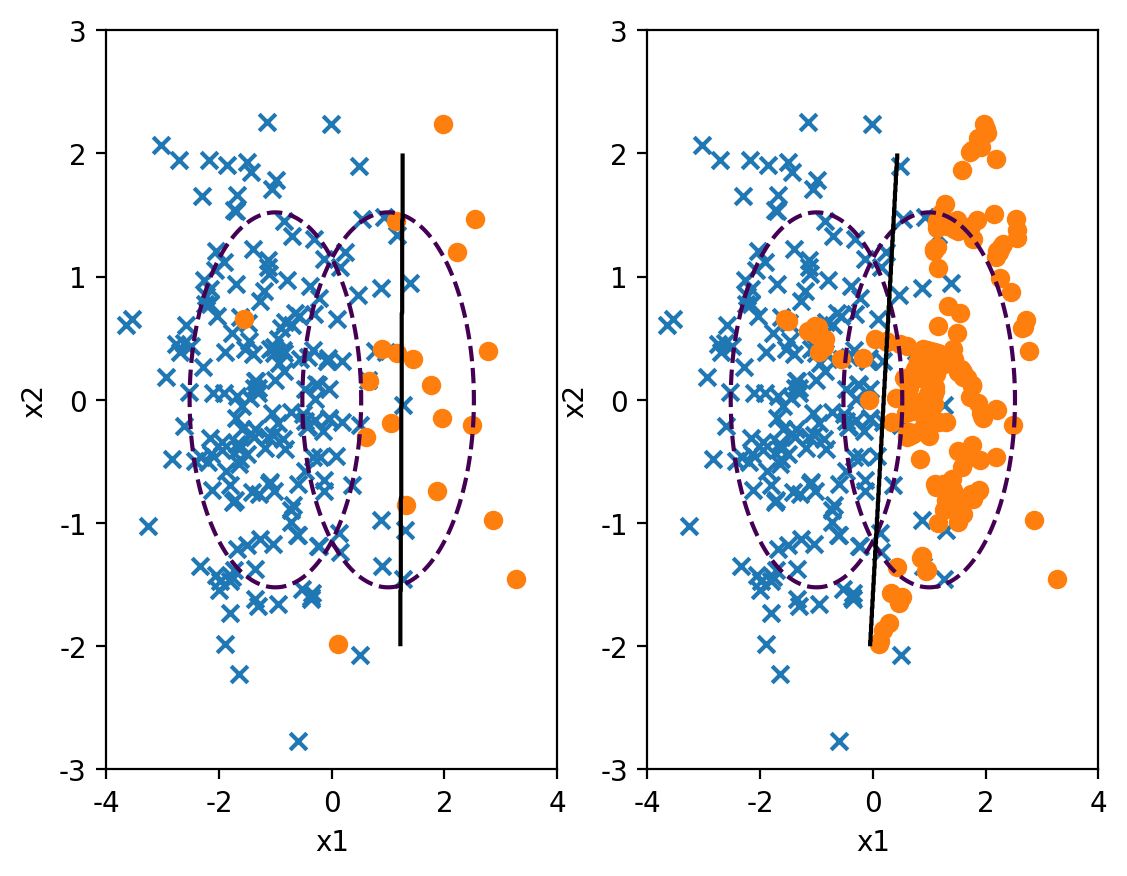

In [31]:
X_samp, y_samp = ADASYN(random_state=0).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [32]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94       200
         1.0       0.47      0.95      0.63        20

    accuracy                           0.90       220
   macro avg       0.73      0.92      0.79       220
weighted avg       0.95      0.90      0.91       220



#### SMOTE(Synthetic Minority Over-sampling Technique)
- SMOTE 방법도 ADASYN 방법처럼 데이터를 생성하지만 생성된 데이터를 무조건 소수 클래스라고 하지 않고 분류 모형에 따라 분류한다.

In [33]:
from imblearn.over_sampling import SMOTE

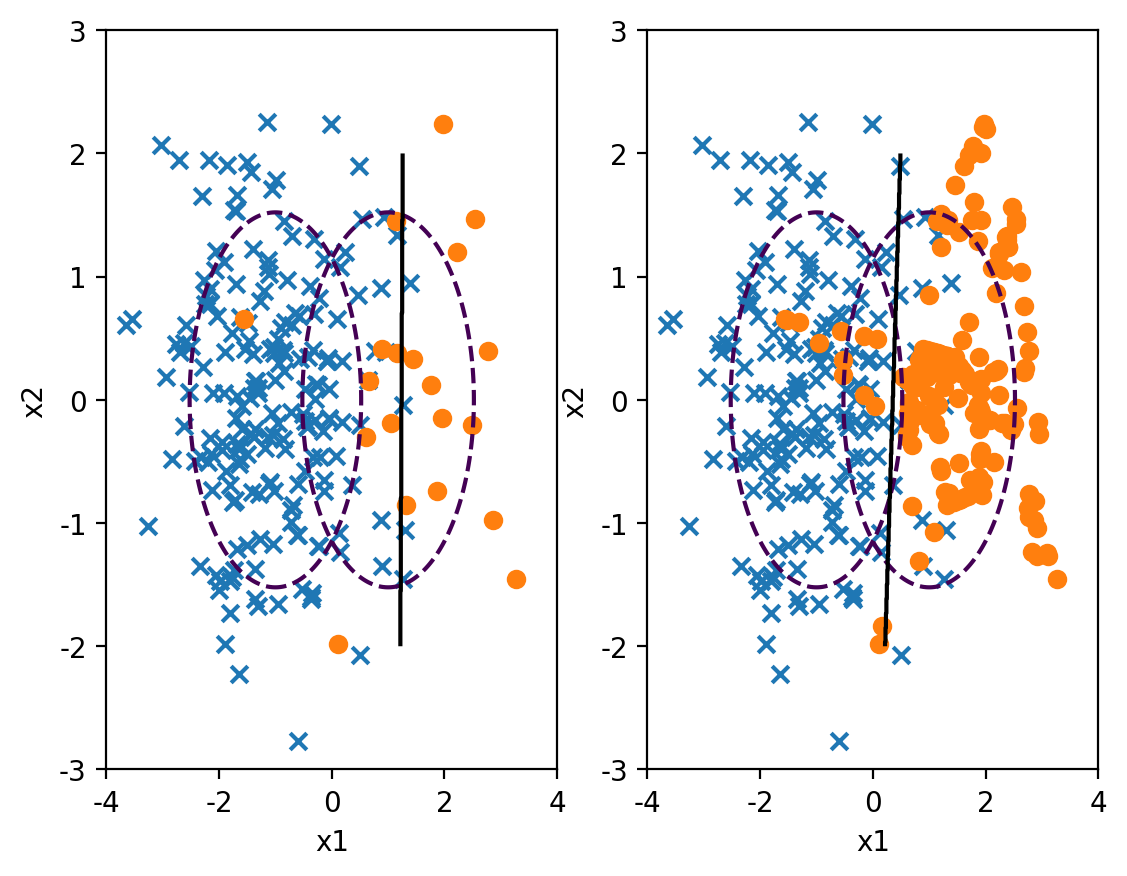

In [34]:
X_samp, y_samp = SMOTE(random_state=4).fit_resample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [35]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95       200
         1.0       0.50      0.90      0.64        20

    accuracy                           0.91       220
   macro avg       0.74      0.91      0.80       220
weighted avg       0.94      0.91      0.92       220

